# Import some libraries and define some functions

In [11]:
import numpy as np
import torchvision
import random
import matplotlib.pyplot as plt

train_data = torchvision.datasets.MNIST(root='data/', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='data/', train=False)

train_data_data = train_data.data.numpy()
train_data_targets = train_data.targets.numpy()
test_data_data = test_data.data.numpy()
test_data_targets = test_data.targets.numpy()

def one_hot(X):                      
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

x_train, x_test = train_data_data / 255.0, test_data_data / 255.0 #

x_train = x_train.reshape(-1,784)  # flatten, (60000,28,28)（60000,784）
x_test = x_test.reshape(-1,784)  # flatten, (10000,28,28)（10000,784）

y_train = one_hot(train_data_targets) 
y_test = one_hot(test_data_targets) #

#----------------------------------------------------------------------------
#some of these functions come from https://blog.csdn.net/weixin_45116099/article/details/127704825

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    x = np.where(x>=0,1,0)
    return x

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)  
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

def accuracy(y1, y2):

    y1 = np.argmax(y1, axis=1)
    y2 = np.argmax(y2, axis=1)

    accuracy = np.sum(y1 == y2) / float(y1.shape[0])
    return accuracy


# Neural Network class

In [28]:
class NeuralNetwork:
    def __init__(self):

        self.layernumber = 0

        self.nodesnumberlist = []     
        self.activationfunctionlist = []
        
        self.dropoutratelist = []
        self.activenodesratelist = []
    
        self.indicelist = []
        
        self.w = []
        self.b = []
        self.z = []
        self.a = []
        
        self.dw = []
        self.db = []
        self.dz = []
        self.da = []
        

    def dropout_weight_matrices(self):
        
        w_origin = self.w.copy()
        b_origin = self.b.copy() 
        
        for i in range(self.layernumber):       #in this example here i is 0. 1, 2. reshape w
           
            ww = self.w[i]                    
            if i == 0:                                   #the first dimension of the first layer is not dropped (784)
                ww = ww[:, self.indicelist[i+1]]            
            elif i == self.layernumber-1:              #other layers both first and second dimension is dropped
                ww = ww[self.indicelist[i]]            
            elif i != self.layernumber-1:                       # the last dimension of the last layer is not dropped(10)
                ww = ww[self.indicelist[i]][:, self.indicelist[i+1]]
            self.w[i] = ww
        
        for i in range(self.layernumber):            #reshape bs
            
            bb = self.b[i]
            if i != self.layernumber - 1:
                bb = bb[self.indicelist[i+1]]
            self.b[i] = bb
        
        return w_origin, b_origin

   
    def weight_matrices_reset(self, w_origin, b_origin):
        
        for i in range(self.layernumber):

            if i == 0:
                w_origin[i][:, self.indicelist[i+1]] = self.w[i]
                self.w[i] = w_origin[i].copy()
            elif i == self.layernumber-1:   
                w_origin[i][self.indicelist[i]] = self.w[i]
                self.w[i] = w_origin[i].copy()
            elif i != self.layernumber-1:   
                temp = w_origin[i].copy()[self.indicelist[i]]
                temp[:, self.indicelist[i+1]] = self.w[i]
                w_origin[i][self.indicelist[i]] = temp
                self.w[i] = w_origin[i].copy()

        for i in range(self.layernumber):
            if i != self.layernumber-1:
                b_origin[i][self.indicelist[i+1]] = self.b[i]
                self.b[i] = b_origin[i].copy()

        
    def add(self, layer):
        self.nodesnumberlist.append(layer.nodes)
        self.layernumber += 1
        self.activationfunctionlist.append(layer.activationfunction)
        self.dropoutratelist.append(layer.dropoutrate)
        self.activenodesratelist.append(1-layer.dropoutrate)
        
     
    def fit(self, x, y, epoches = 10000, initial_lr = 0.05):
        
        #--------------------------------------------------------------------------------------initialising
        
        self.a.append(x)               #the first thing in a list should be x itself
        
        self.nodesnumberlist.insert(0, x.shape[1])        #insert the nodes of the input layer(784 here)        

        for i in range(self.layernumber):             #initialise dimensions here，no training。no dropout.
            
            ww = np.random.randn(self.nodesnumberlist[i], self.nodesnumberlist[i+1]) * 0.01
            self.w.append(ww.copy())                                 #get w list
        
            bb = np.random.randn(self.nodesnumberlist[i+1]) * 0.01
            self.b.append(bb.copy())
        

        #-----------------------------------------------------------------------------------------trainning
        
        self.epochnumberrecordinglist = []                   #prepare some lists to record the training process
        self.crossentropyrecordinglist = []
        self.meansquarederrorrecordinglist = []
        self.testaccuracyrecordinglist = []
                
        for epoch in range(epoches):
            
            lr = initial_lr / (np.sqrt(epoch)+1)             ###################variable learning rate. change this if do not need it variable.
                    
            self.a = []
            self.z = []
            self.a.append(x)
            
            #-------------------------------------------------------------------------------forward process
            
            ################################get the indice list first. Also not needed if dont do dropout
            self.indicelist = []
            for i in range(self.layernumber):
                activenodesnumber = int(self.nodesnumberlist[i] * self.activenodesratelist[i])
                activenodesindice = sorted(random.sample(range(0, self.nodesnumberlist[i]), 
                                      activenodesnumber))
                self.indicelist.append(activenodesindice.copy())
            
            ###########################dropout. Comment next sentence if do not need dropout
            w_origin, b_origin = self.dropout_weight_matrices()    
            
            for i in range(self.layernumber):
                #print(i)
                zz = np.dot(self.a[i], self.w[i]) + self.b[i]
                #self.z[i] = zz.copy()                    #calculate z
                self.z.append(zz.copy())
                
                if self.activationfunctionlist[i] == 'relu':
                    aa = relu(zz).copy()
                elif self.activationfunctionlist[i] == 'sigmoid':
                    aa = sigmoid(zz).copy()
                elif self.activationfunctionlist[i] == 'softmax':
                    aa = softmax(zz).copy()          
                #self.a[i+1] = aa.copy()                    #calculate a, notice here a[0] is x_train, so after that is a[i+1]
                self.a.append(aa.copy())
            
            y_temp = self.a[-1].copy()                 #temporary predict result
            
            #------------------------------------------------------------------------------Print something during training
            
            if (epoch+1) % 100 == 0:                          #print something every 100 epoch
                y_test_temp = self.predict(x_test)                 #calculate the currently predicted values
                print('epoch', epoch+1, 'lr', lr, 'test accuracy:', accuracy(y_test_temp, y_test))
                print('crossentropyerror:', cross_entropy_error(y_temp, y), 'mse:', mean_squared_error(y_temp, y))
                self.epochnumberrecordinglist.append(epoch+1)
                self.crossentropyrecordinglist.append(cross_entropy_error(y_temp, y))
                self.meansquarederrorrecordinglist.append(mean_squared_error(y_temp, y))
                self.testaccuracyrecordinglist.append(accuracy(y_test_temp, y_test))
                
                #stop criteria. After 2000 epoches, If test accuracy does not grow in 10 checkpoints (100 epoches per checkpoint), then stop training.
                if epoch > 2000:
                    if max([testaccuracyrecordinglist[i]- self.testaccuracyrecordinglist[i-1] for i in range (-10, 0)]) <= 0:
                        print('current epoch', (epoch+1), 'stop training', 'test accuracy:', accuracy(y_test_temp, y_test))
                        break
                        

            #------------------------------------------------------------------------------backward process
            
            self.dw = []     #clear these four again
            self.db = []
            self.dz = []
            self.da = []
            
            for i in range(self.layernumber):
            
                if self.activationfunctionlist[self.layernumber-i-1] == 'softmax':            #dz
                    dzz = ( y_temp - y ) / x.shape[0]
                elif self.activationfunctionlist[self.layernumber-i-1] == 'relu':
                    dzz = relu_grad(self.a[self.layernumber-i]) * daa #/ x.shape[0]
                elif self.activationfunctionlist[self.layernumber-i-1] == 'sigmoid':
                    dzz = sigmoid_grad(self.a[self.layernumber-i]) * daa #/ x.shape[0]
                self.dz.insert(0, dzz.copy())
                
                dww = np.dot(self.a[self.layernumber-i-1].T, dzz)                            #get dw, needed
                self.dw.insert(0, dww.copy())
                
             
                daa = np.dot(dzz, self.w[self.layernumber-i-1].T)                                                   # da
                self.da.insert(0, daa.copy())
                
                dbb = np.sum(dzz, axis=0)                                                            #get db, needed
                self.db.insert(0, dbb)
            
            for i in range(self.layernumber):
                self.w[i] = (self.w[i] - lr * self.dw[i]).copy()
                self.b[i] = (self.b[i] - lr * self.db[i]).copy()

            ###############################dropout reset size. comment the next sentence if do not need dropout
            self.weight_matrices_reset(w_origin, b_origin)           #reset w, after backward propagation
        

        
    def predict(self, x):
        
        self.a2 = []
        self.z2 = []
            
        self.a2.append(x)
        for i in range(self.layernumber):
            
            zz = np.dot(self.a2[i], self.w[i]) + self.b[i]
            #self.z[i] = zz.copy()                    #calculate z
            
            if self.activationfunctionlist[i] == 'relu':
                aa = relu(zz)
            elif self.activationfunctionlist[i] == 'sigmoid':
                aa = sigmoid(zz)
            elif self.activationfunctionlist[i] == 'softmax':
                aa = softmax(zz)            
            #self.a[i+1] = aa.copy()                    #calculate a, notice here a[0] is x_train, so after that is a[i+1]
            self.a2.append(aa)
        
        y_temp = self.a2[-1]

        return y_temp
        

# Layer class

In [15]:
class DenseLayer:
    def __init__(self, nodes, activationfunction = 'relu', dropoutrate = 0):
        self.nodes = nodes
        self.activationfunction = activationfunction
        self.dropoutrate = dropoutrate

# Test some neural network structures

First have a look at a basic one hidden layer net without dropout

In [22]:
nn1  = NeuralNetwork()
nn1.add(DenseLayer(100, 'relu', 0))
nn1.add(DenseLayer(10, 'softmax', 0))
nn1.fit(x_train, y_train, 15000, initial_lr = 2)

epoch 100 lr 0.18265049736869796 test accuracy: 0.8916
crossentropyerror: 0.4152259254283025 mse: 5511.847106433269
epoch 200 lr 0.13239127252187763 test accuracy: 0.9049
crossentropyerror: 0.3508338655690311 mse: 4644.567151948487
epoch 300 lr 0.10933970782409787 test accuracy: 0.9097
crossentropyerror: 0.3263165003955699 mse: 4323.191632144328
epoch 400 lr 0.09535168017808131 test accuracy: 0.9138
crossentropyerror: 0.3123308856552911 mse: 4141.491917471282
epoch 500 lr 0.08569601567746457 test accuracy: 0.9166
crossentropyerror: 0.3029177511599112 mse: 4019.6463322598315
epoch 600 lr 0.07850995485297939 test accuracy: 0.9187
crossentropyerror: 0.29597608727141295 mse: 3929.916589345551
epoch 700 lr 0.07288999464986982 test accuracy: 0.9201
crossentropyerror: 0.2905499524275304 mse: 3859.777519864053
epoch 800 lr 0.06833731340903544 test accuracy: 0.9217
crossentropyerror: 0.2861363171099224 mse: 3802.7005812683806
epoch 900 lr 0.06455084343236057 test accuracy: 0.9225
crossentropyer

epoch 7100 lr 0.02345887957580092 test accuracy: 0.9297
crossentropyerror: 0.23386732770556343 mse: 3119.149556347876
epoch 7200 lr 0.02329728285114169 test accuracy: 0.9299
crossentropyerror: 0.23359841279810645 mse: 3115.647917581932
epoch 7300 lr 0.02313899292830607 test accuracy: 0.93
crossentropyerror: 0.23333371093895808 mse: 3112.2028744625754
epoch 7400 lr 0.022983898375807395 test accuracy: 0.9298
crossentropyerror: 0.2330732227526399 mse: 3108.814457903521
epoch 7500 lr 0.022831892953664723 test accuracy: 0.9298
crossentropyerror: 0.23281674738153332 mse: 3105.4796663797883
epoch 7600 lr 0.022682875306341152 test accuracy: 0.9298
crossentropyerror: 0.23256420466590705 mse: 3102.197518030429
epoch 7700 lr 0.022536748677600752 test accuracy: 0.9298
crossentropyerror: 0.232315362843695 mse: 3098.9639628390805
epoch 7800 lr 0.022393420645458184 test accuracy: 0.9297
crossentropyerror: 0.23207011629056523 mse: 3095.778759917101
epoch 7900 lr 0.022252802875568436 test accuracy: 0.9

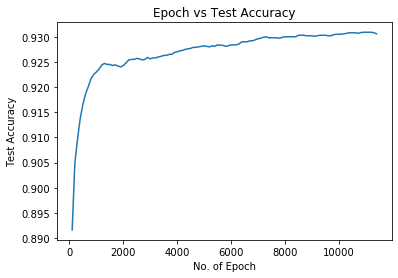

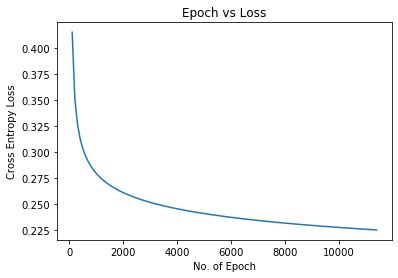

In [24]:
plt.plot(nn1.epochnumberrecordinglist, nn1.testaccuracyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Test Accuracy")
plt.title("Epoch vs Test Accuracy")
plt.show()

plt.plot(nn1.epochnumberrecordinglist, nn1.crossentropyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Epoch vs Loss")
plt.show()

Here we can see that when training stopped because of the stopping criteria the accuracy is about 0.93 at epoch 11400 and the test accuracy seems still improvable.

Then we take a look whether dropout helps. This network is mostly the same as the last one, except a dropout rate 0.1

In [32]:
nn2  = NeuralNetwork()
nn2.add(DenseLayer(100, 'relu', 0.1))
nn2.add(DenseLayer(10, 'softmax', 0.1))
nn2.fit(x_train, y_train, 10000, initial_lr=2)


epoch 100 lr 0.18265049736869796 test accuracy: 0.8581
crossentropyerror: 0.5342599995012561 mse: 7156.370377906589
epoch 200 lr 0.13239127252187763 test accuracy: 0.8831
crossentropyerror: 0.4620189333722534 mse: 6102.9862585939645
epoch 300 lr 0.10933970782409787 test accuracy: 0.8929
crossentropyerror: 0.4230346270433194 mse: 5525.10201764924
epoch 400 lr 0.09535168017808131 test accuracy: 0.8904
crossentropyerror: 0.4215507247809744 mse: 5580.918101014406
epoch 500 lr 0.08569601567746457 test accuracy: 0.8953
crossentropyerror: 0.3996043792170436 mse: 5236.368579149813
epoch 600 lr 0.07850995485297939 test accuracy: 0.8933
crossentropyerror: 0.4181777661711519 mse: 5496.64130839299
epoch 700 lr 0.07288999464986982 test accuracy: 0.8931
crossentropyerror: 0.4111020963016377 mse: 5442.787909428702
epoch 800 lr 0.06833731340903544 test accuracy: 0.887
crossentropyerror: 0.4374298828757583 mse: 5783.650988465613
epoch 900 lr 0.06455084343236057 test accuracy: 0.8893
crossentropyerror: 

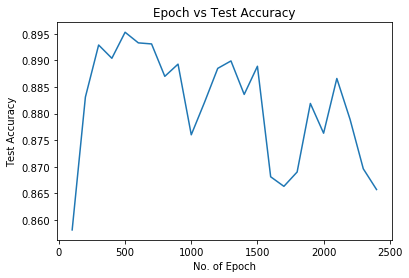

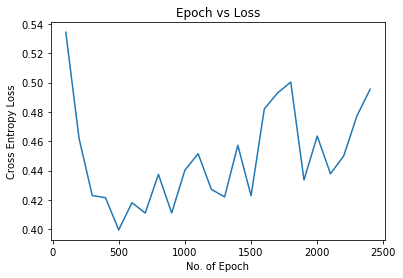

In [33]:
plt.plot(nn2.epochnumberrecordinglist, nn2.testaccuracyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Test Accuracy")
plt.title("Epoch vs Test Accuracy")
plt.show()

plt.plot(nn2.epochnumberrecordinglist, nn2.crossentropyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Epoch vs Loss")
plt.show()

We can find that dropout makes the training curve is shocking and dropout does not increase the accuracy.

Finally let's have a look at a two-hidden-layer net. Only here we commented the lr-changing code and applied a constant learning rate 0.5.

In [12]:
nn3  = NeuralNetwork()
nn3.add(DenseLayer(200, 'sigmoid', 0))
nn3.add(DenseLayer(50, 'relu', 0))
nn3.add(DenseLayer(10, 'softmax', 0))
nn3.fit(x_train, y_train, 5000, initial_lr = 0.5)

epoch 100 test accuracy: 0.1135
crossentropyerror: 2.298780504685542 mse: 26976.533775620155
epoch 200 test accuracy: 0.2487
crossentropyerror: 1.956759108329355 mse: 24572.40426150892
epoch 300 test accuracy: 0.567
crossentropyerror: 1.0954334768069678 mse: 16035.08161466444
epoch 400 test accuracy: 0.8072
crossentropyerror: 0.5820972640515708 mse: 8291.631058525743
epoch 500 test accuracy: 0.8522
crossentropyerror: 0.4754496797457202 mse: 6525.867243515739
epoch 600 test accuracy: 0.8715
crossentropyerror: 0.41709735272691434 mse: 5653.00765449619
epoch 700 test accuracy: 0.8872
crossentropyerror: 0.37299184841343724 mse: 5031.465554799987
epoch 800 test accuracy: 0.8982
crossentropyerror: 0.3382847308868641 mse: 4546.002255633008
epoch 900 test accuracy: 0.9067
crossentropyerror: 0.3136538204491101 mse: 4213.800353289029
epoch 1000 test accuracy: 0.91
crossentropyerror: 0.2968708175683041 mse: 3995.772970656765
epoch 1100 test accuracy: 0.9126
crossentropyerror: 0.28460273054676744 

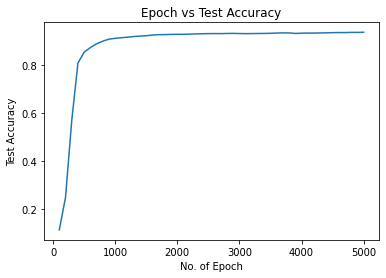

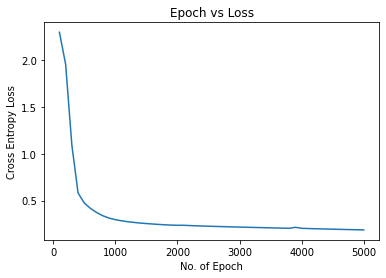

In [13]:
plt.plot(nn3.epochnumberrecordinglist, nn3.testaccuracyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Test Accuracy")
plt.title("Epoch vs Test Accuracy")
plt.show()

plt.plot(nn3.epochnumberrecordinglist, nn3.crossentropyrecordinglist)
plt.xlabel("No. of Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Epoch vs Loss")
plt.show()

We can see that when training stopped at define epoch 5000 it has reached its highest performance.Both curves are relatively smooth. However, each training epoch takes much longer time than a one-hidden layer network.